In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from backtest import backtest
from plotting import plot_fills
from downloader import load_hlc_cache
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    round_dynamic,
    round_values,
    sort_dict_keys,
)
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

using numba
using numba
using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [4]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/default.hjson"
        self.exchange = "binance"
        self.symbol = "XMRUSDT"
        self.market_type = "futures"
        self.user = "binance_01"
        self.start_date = "2022-06-20"
        self.end_date = "2023-01-20"
        self.starting_balance = 1000.0
        self.starting_configs = ""
        self.base_dir = "backtests"
        self.ohlcv = True  # always True for clock mode


config = await prepare_backtest_config(Args())
sts = time()
data = load_hlc_cache(
    config["symbol"],
    config["start_date"],
    config["end_date"],
    base_dir=config["base_dir"],
    spot=config["spot"],
    exchange=config["exchange"],
)
prices = data[:, 3]
highs = data[:, 1]
lows = data[:, 2]
closes = data[:, 3]
timestamps = data[:, 0]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings...
linear perpetual
initiating position, open orders, fills, exchange config, order book, and emas...
2023-04-06T08:45:33  {'code': -2015, 'msg': 'Invalid API-key, IP, or permissions for action'} 
2023-04-06T08:45:34  {'code': -2015, 'msg': 'Invalid API-key, IP, or permissions for action'} 
2023-04-06T08:45:34  {'code': -2015, 'msg': 'Invalid API-key, IP, or permissions for action'} 
done
first ohlcv at 2020-02-03T15:03:00
fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2022-08.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.55M/1.55M [00:00<00:00, 1.90MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2022-09.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.46M/1.46M [00:00<00:00, 1.92MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2022-10.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.49M/1.49M [00:00<00:00, 2.97MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2022-11.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.46M/1.46M [00:00<00:00, 2.54MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2022-12.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.48M/1.48M [00:00<00:00, 3.65MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2023-01.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.52M/1.52M [00:00<00:00, 3.77MB/s]


XMRUSDT most n days of consecutive identical ohlcvs: 0.003, index last: 290781
millis to load 308161 ticks 9824ms


<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

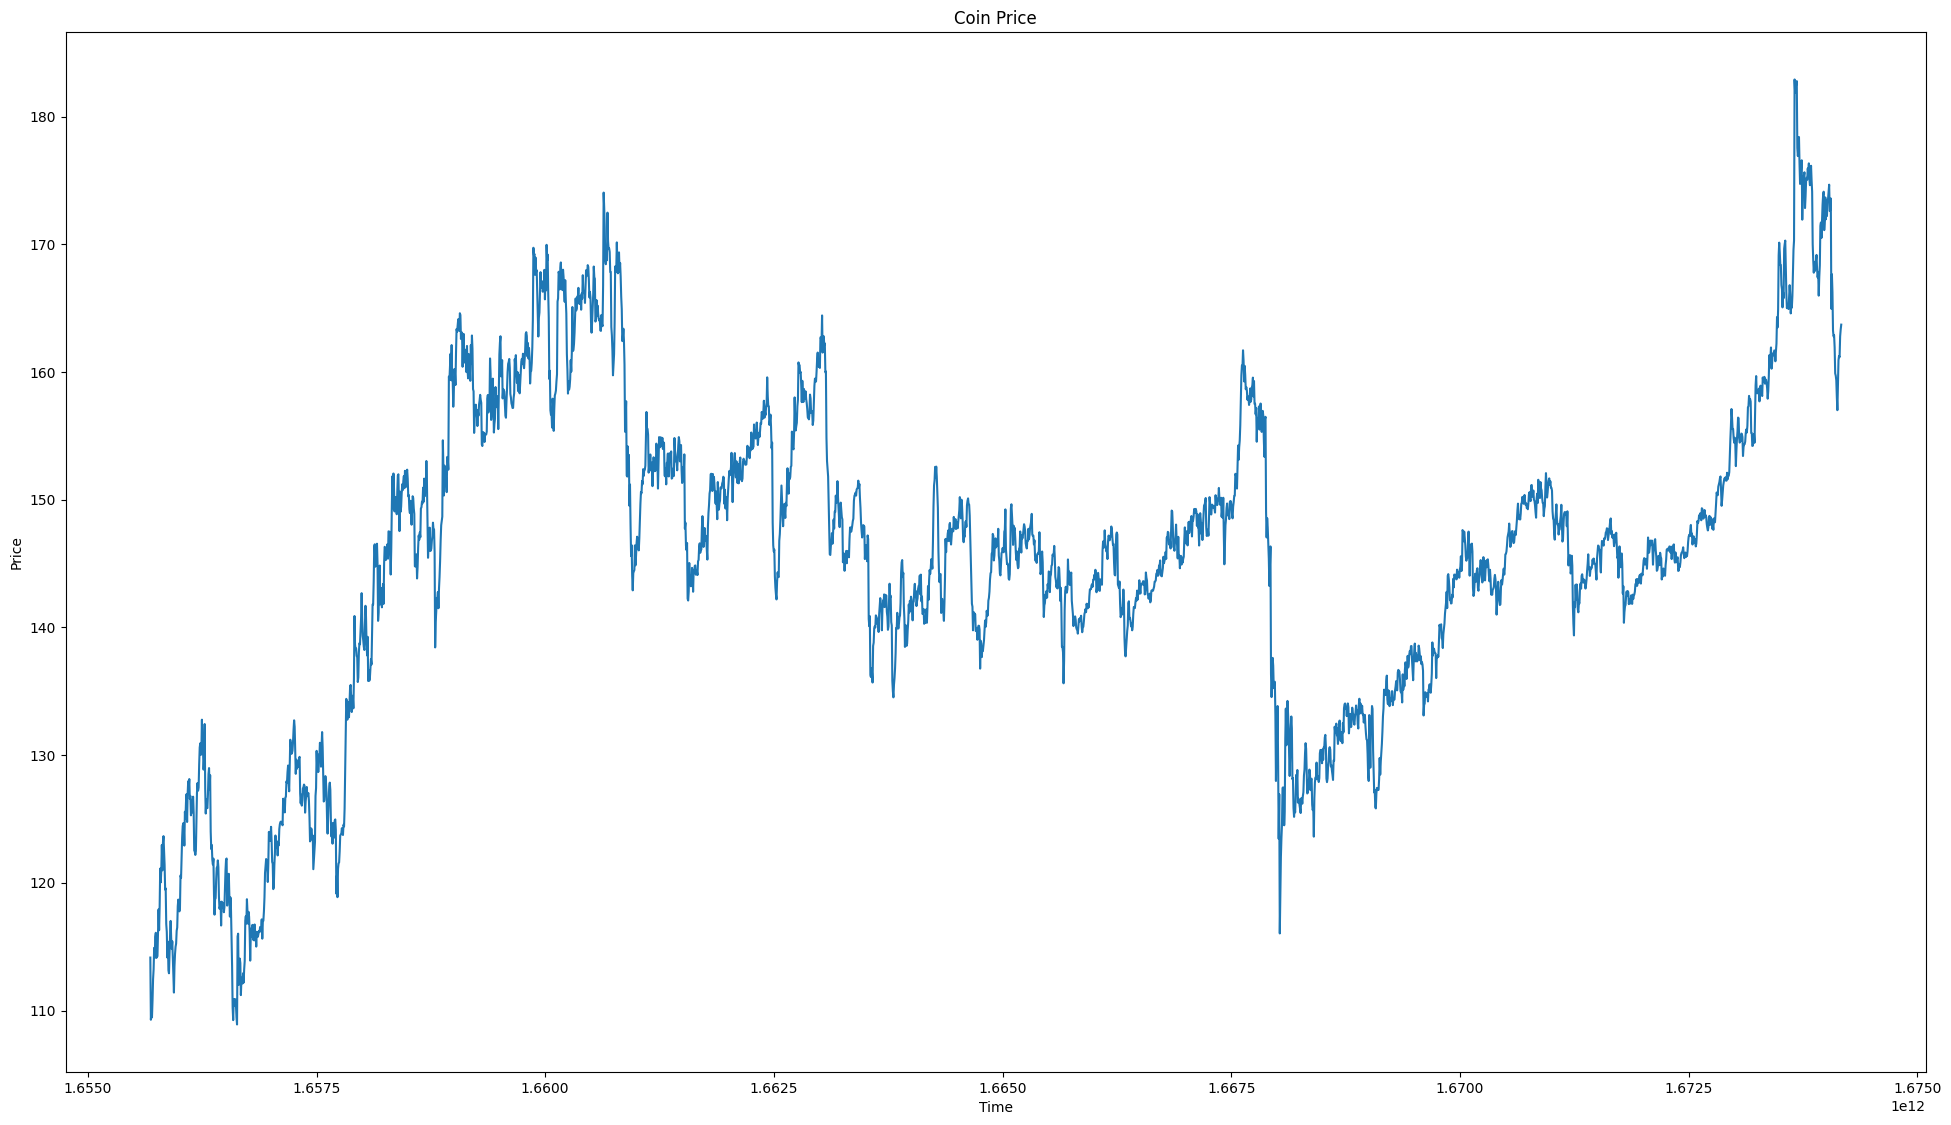

In [5]:
df = pd.DataFrame({"timestamp": timestamps, "price": prices}).set_index("timestamp")
df.price.iloc[::100].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [6]:
hand_tuned = {
    "config_name": "emas_0days",
    "long": {
        "delay_between_fills_minutes_close": 703.3,
        "delay_between_fills_minutes_entry": 187.5,
        "delay_weight_close": 3.989,
        "delay_weight_entry": 8.921,
        "ema_dist_lower": 0.0008584,
        "ema_dist_upper": 0.007752,
        "ema_span_0": 954.0,
        "ema_span_1": 124.3,
        "enabled": True,
        "markup_range": 0.06996,
        "min_markup": 0.02848,
        "n_close_orders": 14,
        "qty_pct_close": 0.09392,
        "qty_pct_entry": 0.01674,
        "wallet_exposure_limit": 1.0,
        "we_multiplier_close": 7.798,
        "we_multiplier_entry": 6.95,
    },
    "short": {
        "delay_between_fills_minutes_close": 1172.0,
        "delay_between_fills_minutes_entry": 1351.0,
        "delay_weight_close": 2.832,
        "delay_weight_entry": 15.12,
        "ema_dist_lower": 0.005519,
        "ema_dist_upper": 0.004033,
        "ema_span_0": 1251.0,
        "ema_span_1": 1830.0,
        "enabled": True,
        "markup_range": 0.06225,
        "min_markup": 0.06723,
        "n_close_orders": 5,
        "qty_pct_close": 0.06165,
        "qty_pct_entry": 0.01561,
        "wallet_exposure_limit": 1.0,
        "we_multiplier_close": 9.278,
        "we_multiplier_entry": 49.73,
    },
}

config_to_test = {**config, **hand_tuned}

In [7]:
sts = time()
fills_long, fills_short, stats = backtest(config_to_test, data)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test)
pprint.pprint(analysis)

seconds elapsed 27.5065
{'adg_long': 0.001129821616952631,
 'adg_per_exposure_long': 0.001129821616952631,
 'adg_per_exposure_short': 0.0008375366606585555,
 'adg_realized_long': 0.001129821616952631,
 'adg_realized_per_exposure_long': 0.001129821616952631,
 'adg_realized_per_exposure_short': 0.0008375366606585555,
 'adg_realized_short': 0.0008375366606585555,
 'adg_short': 0.0008375366606585555,
 'avg_fills_per_day_long': 5.878523749103547,
 'avg_fills_per_day_short': 2.023371051956944,
 'closest_bkr_long': 0.999961875268498,
 'closest_bkr_short': 0.9171712333221113,
 'eqbal_ratio_mean_long': 0.9993410223995007,
 'eqbal_ratio_mean_short': 0.9994667342879773,
 'eqbal_ratio_min_long': 0.939550280802609,
 'eqbal_ratio_min_short': 0.9568615919658823,
 'equity_balance_ratio_mean_long': 0.9993410223995007,
 'equity_balance_ratio_mean_short': 0.9994667342879773,
 'equity_balance_ratio_std_long': 0.0038456249448388905,
 'equity_balance_ratio_std_short': 0.002937407270229574,
 'exchange': 'bin

In [8]:
sdf

,timestamp,bkr_price_long,bkr_price_short,psize_long,pprice_long,psize_short,pprice_short,price,closest_bkr_long,closest_bkr_short,balance_long,balance_short,equity_long,equity_short,wallet_exposure_long,wallet_exposure_short
0,1655683260000.0,0.0,0.000000000,0.000,0.0000000000,-0.000,0.00,114.05,1.0000000000,1.0000000000,1000.0000000000,1000.000000000,1000.000000000,1000.000000000,0.0000000000,0.0000000000
1,1655686860000.0,0.0,0.000000000,0.147,114.0500000000,-0.000,0.00,111.53,1.0000000000,1.0000000000,999.9966469300,1000.144754864,999.626206930,1000.144754864,0.0167654062,0.0000000000
2,1655690460000.0,0.0,0.000000000,0.147,114.0500000000,-0.000,0.00,110.18,1.0000000000,1.0000000000,999.9966469300,1000.144754864,999.427756930,1000.144754864,0.0167654062,0.0000000000
3,1655694060000.0,0.0,0.000000000,0.317,111.9692429022,-0.000,0.00,109.46,1.0000000000,1.0000000000,999.9929011500,1000.144754864,999.197471150,1000.144754864,0.0354945020,0.0000000000
4,1655697660000.0,0.0,0.000000000,0.317,111.9692429022,-0.000,0.00,110.26,1.0000000000,1.0000000000,999.9929011500,1000.144754864,999.451071150,1000.144754864,0.0354945020,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5132,1674158460000.0,0.0,10656.399928386,0.545,161.3756466598,-0.114,163.34,163.05,0.9999618753,0.9171712333,1273.3415152216,1196.208831836,1274.254037792,1196.241891836,0.0690700228,0.0155664793
5133,1674162060000.0,0.0,10656.399928386,0.545,161.3756466598,-0.114,163.34,163.63,0.9999618753,0.9171712333,1273.3415152216,1196.208831836,1274.570137792,1196.175771836,0.0690700228,0.0155664793
5134,1674165660000.0,0.0,10656.399928386,0.545,161.3756466598,-0.114,163.34,162.00,0.9999618753,0.9171712333,1273.3415152216,1196.208831836,1273.681787792,1196.361591836,0.0690700228,0.0155664793
5135,1674169260000.0,0.0,10656.399928386,0.545,161.3756466598,-0.114,163.34,163.88,0.9999618753,0.9171712333,1273.3415152216,1196.208831836,1274.706387792,1196.147271836,0.0690700228,0.0155664793


<AxesSubplot:title={'center':'Balance and equity long'}, xlabel='Time', ylabel='Balance'>

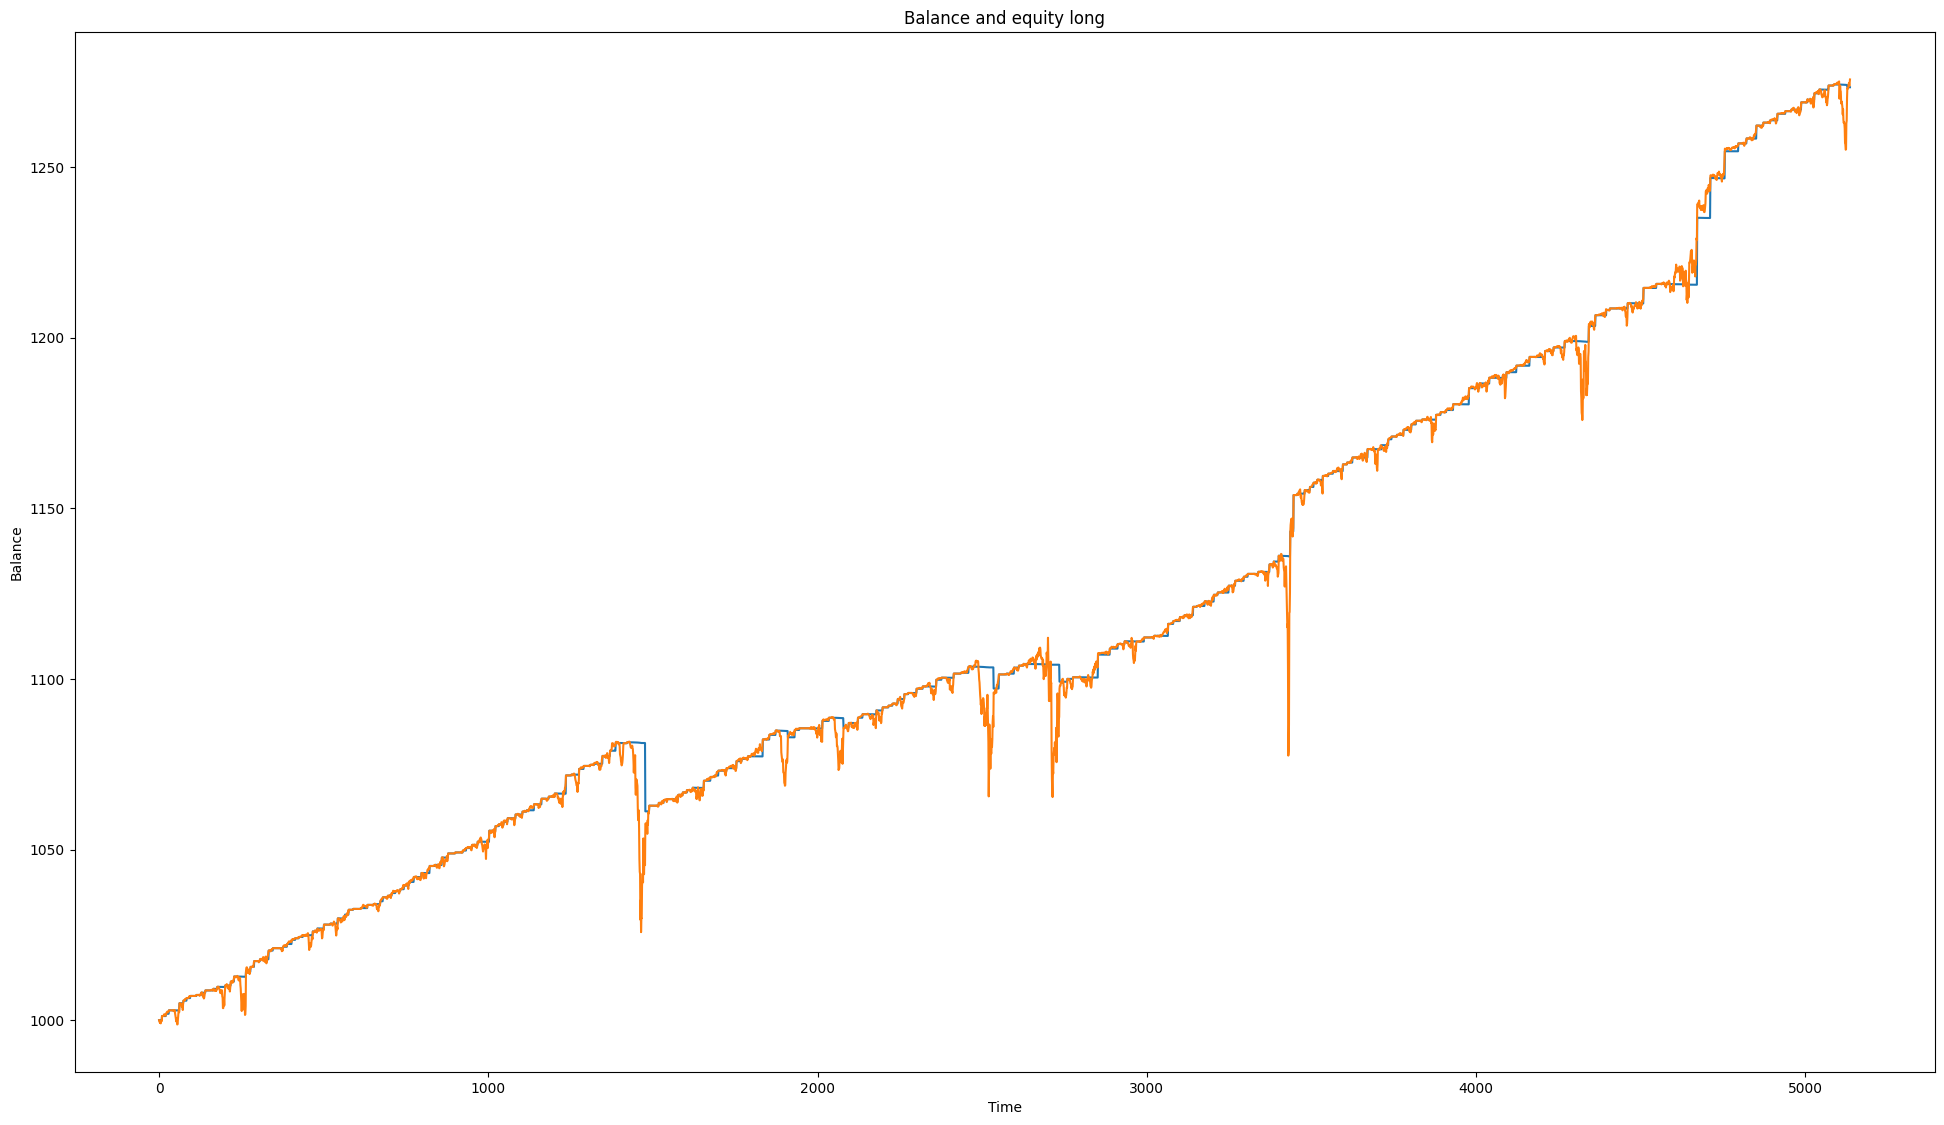

In [9]:
sdf.balance_long.plot()
sdf.equity_long.plot(title="Balance and equity long", xlabel="Time", ylabel="Balance")

<AxesSubplot:title={'center':'Balance and equity short'}, xlabel='Time', ylabel='Balance'>

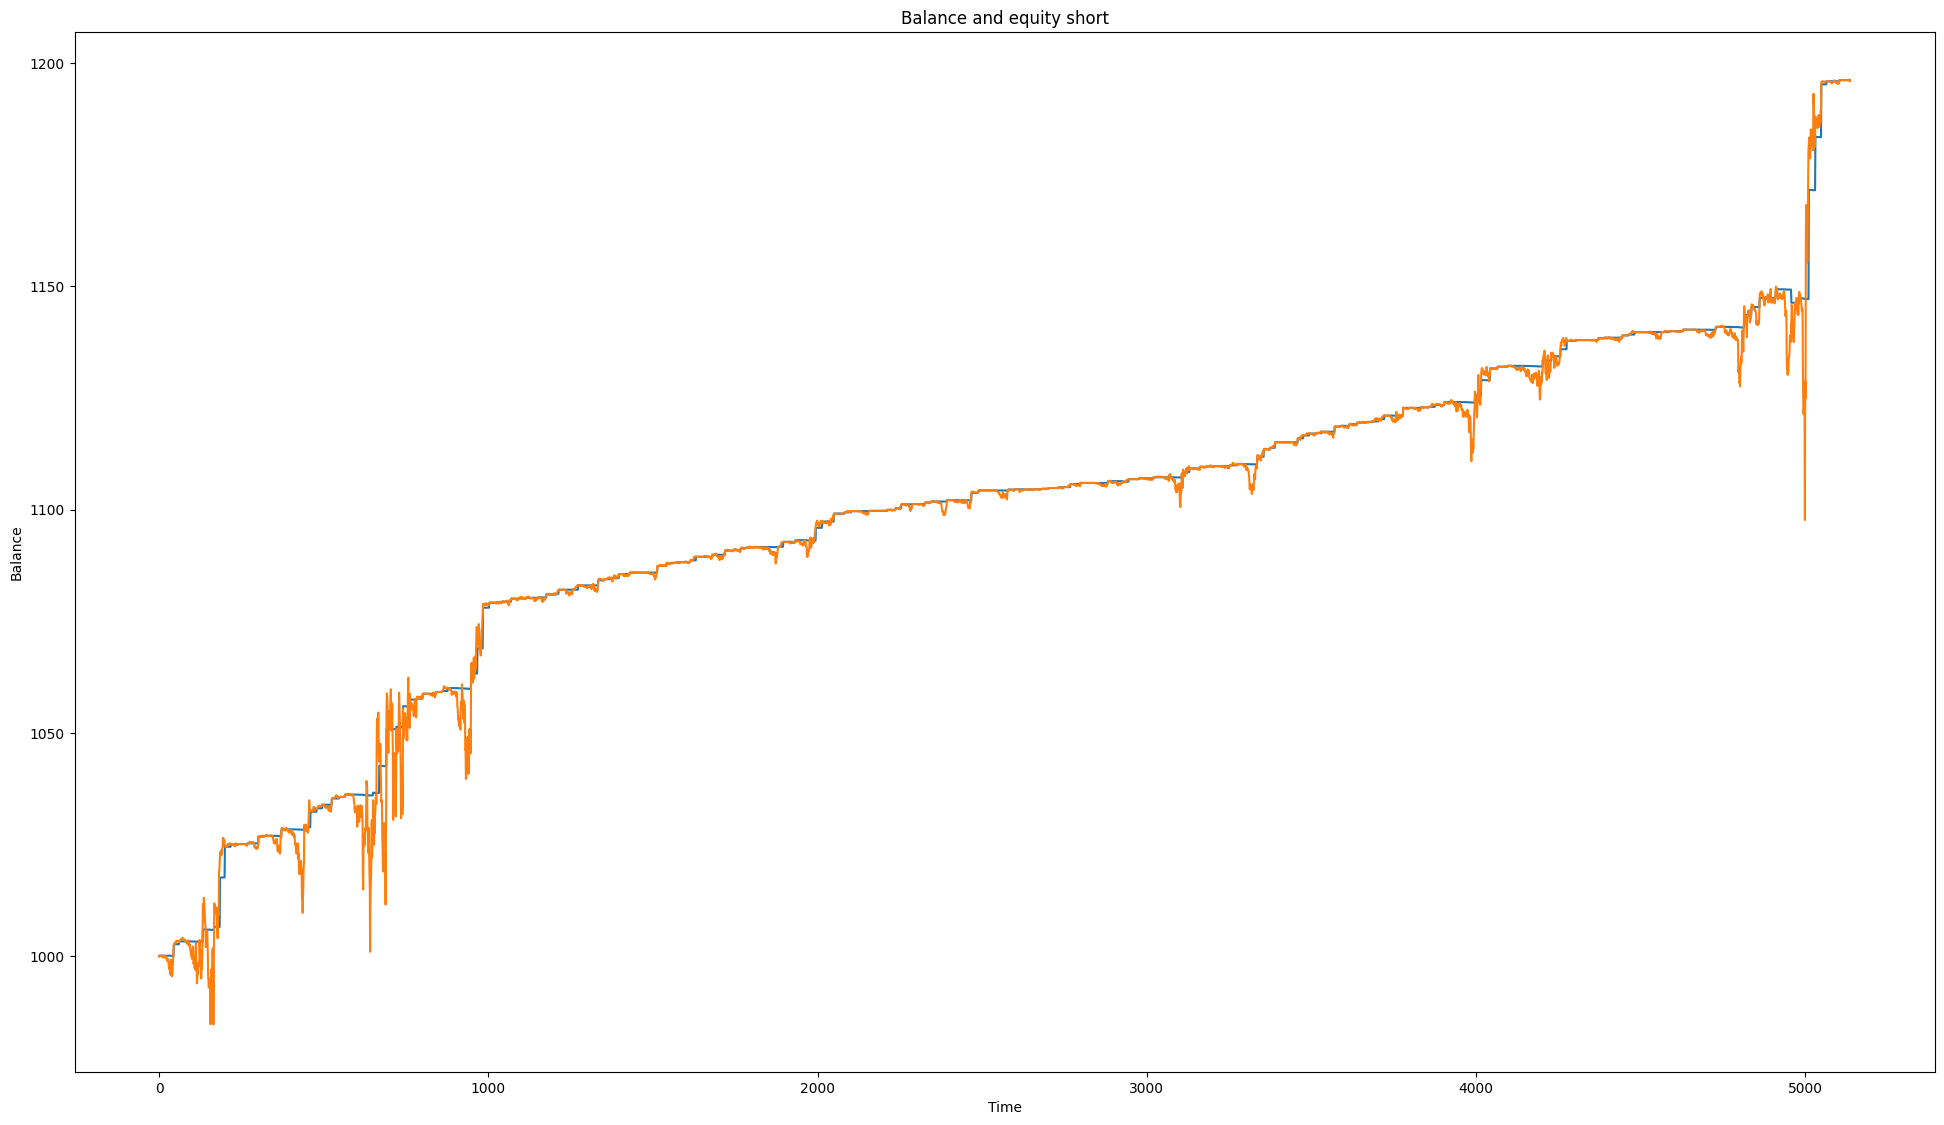

In [10]:
sdf.balance_short.plot()
sdf.equity_short.plot(title="Balance and equity short", xlabel="Time", ylabel="Balance")

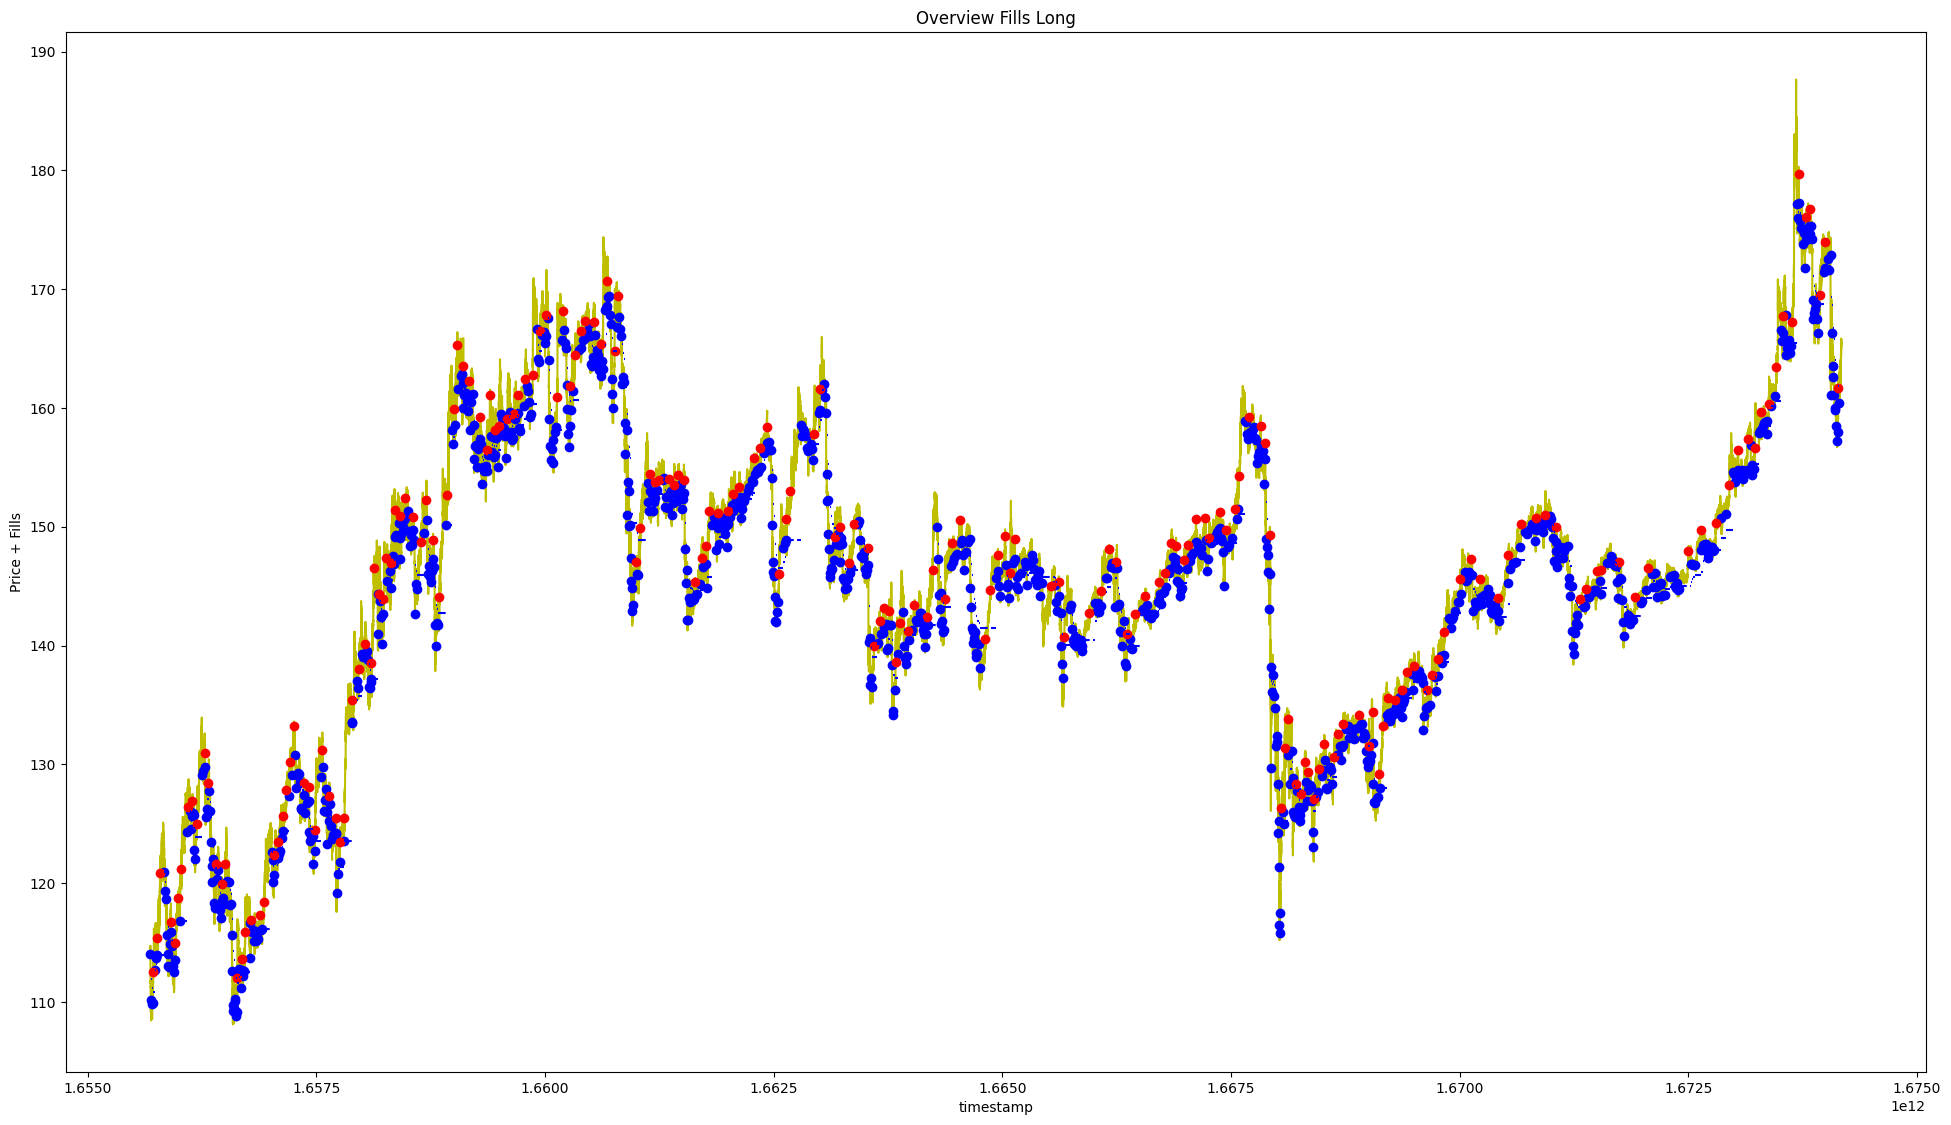

In [11]:
if len(longs) > 0:
    plot_fills(df, longs, plot_whole_df=True, title="Overview Fills Long")

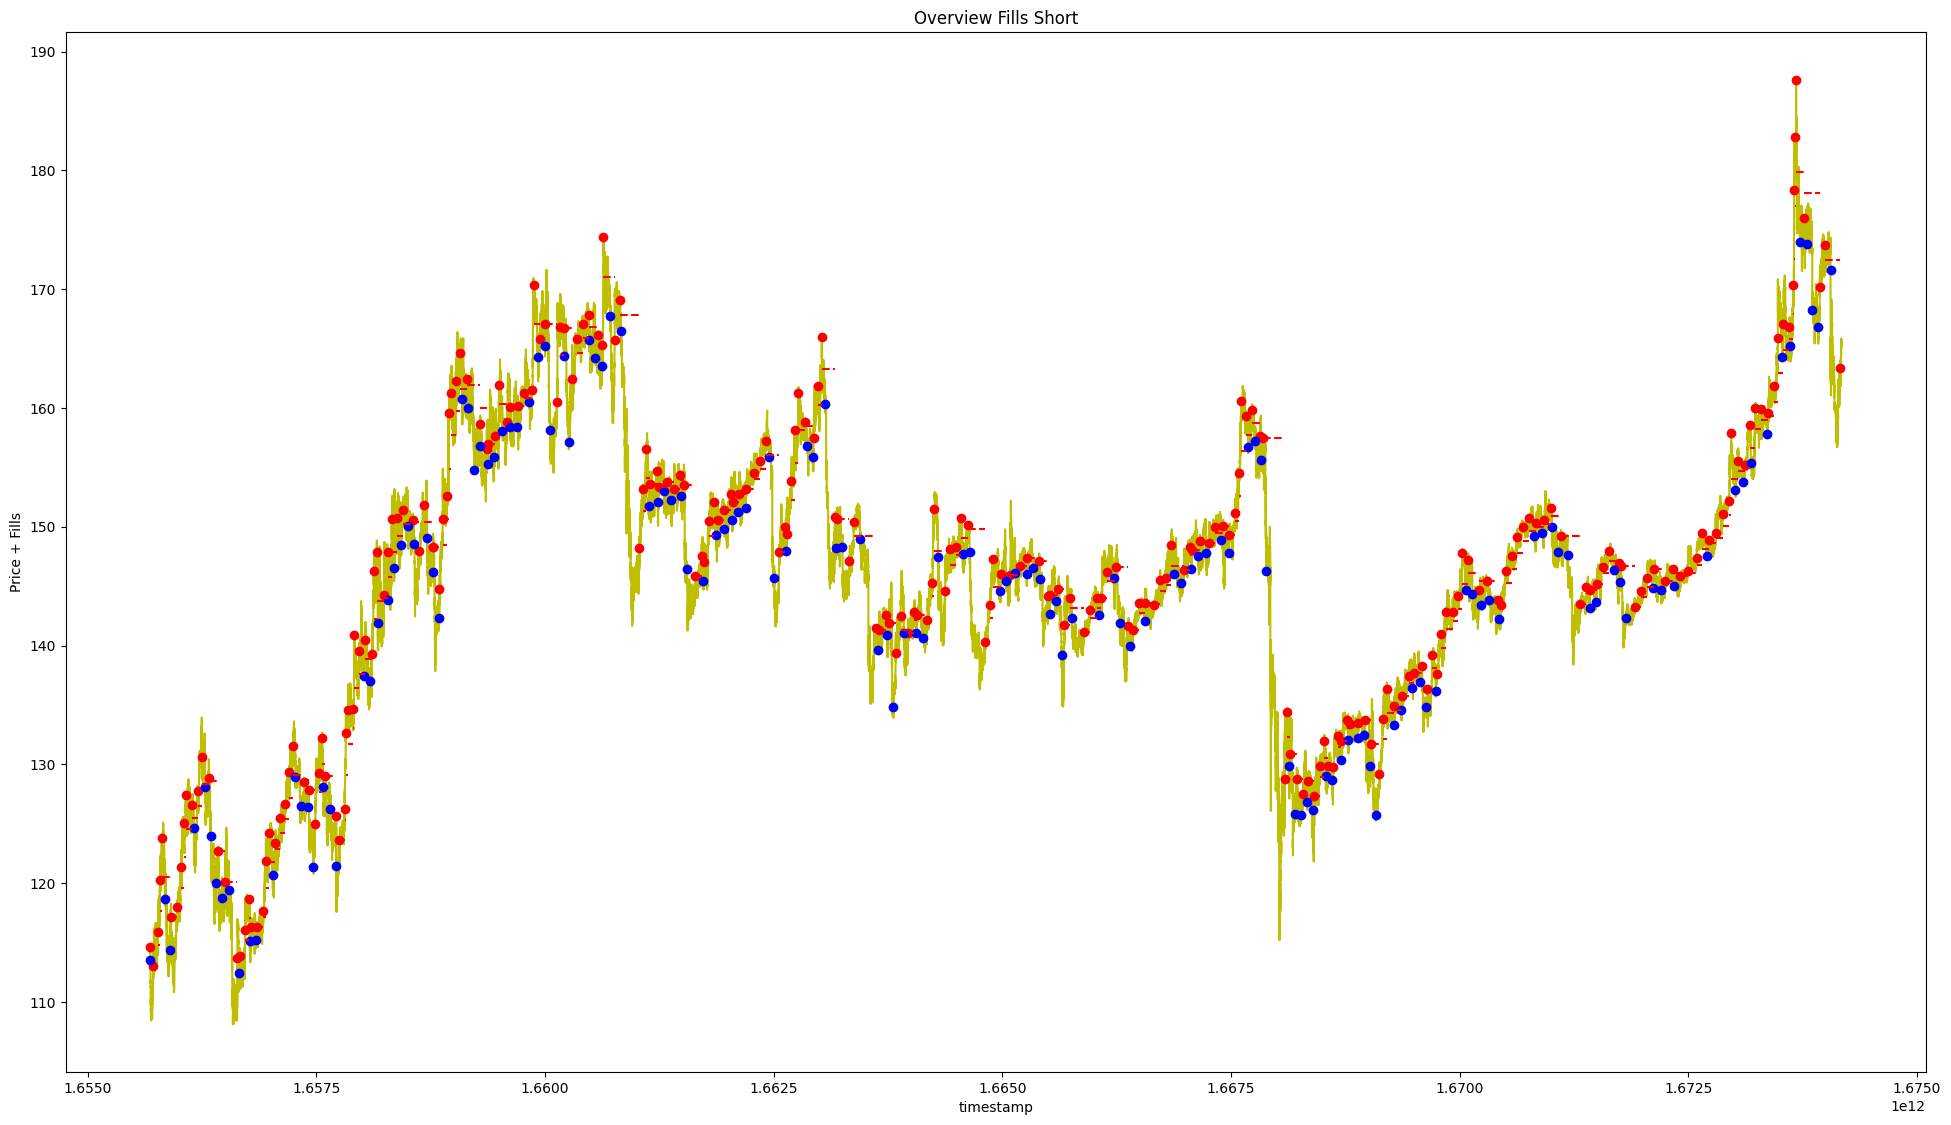

In [12]:
if len(shorts) > 0:
    plot_fills(df, shorts, plot_whole_df=True, title="Overview Fills Short")

<AxesSubplot:title={'center':'Wallet exposures'}, xlabel='Time', ylabel='Wallet Exposure'>

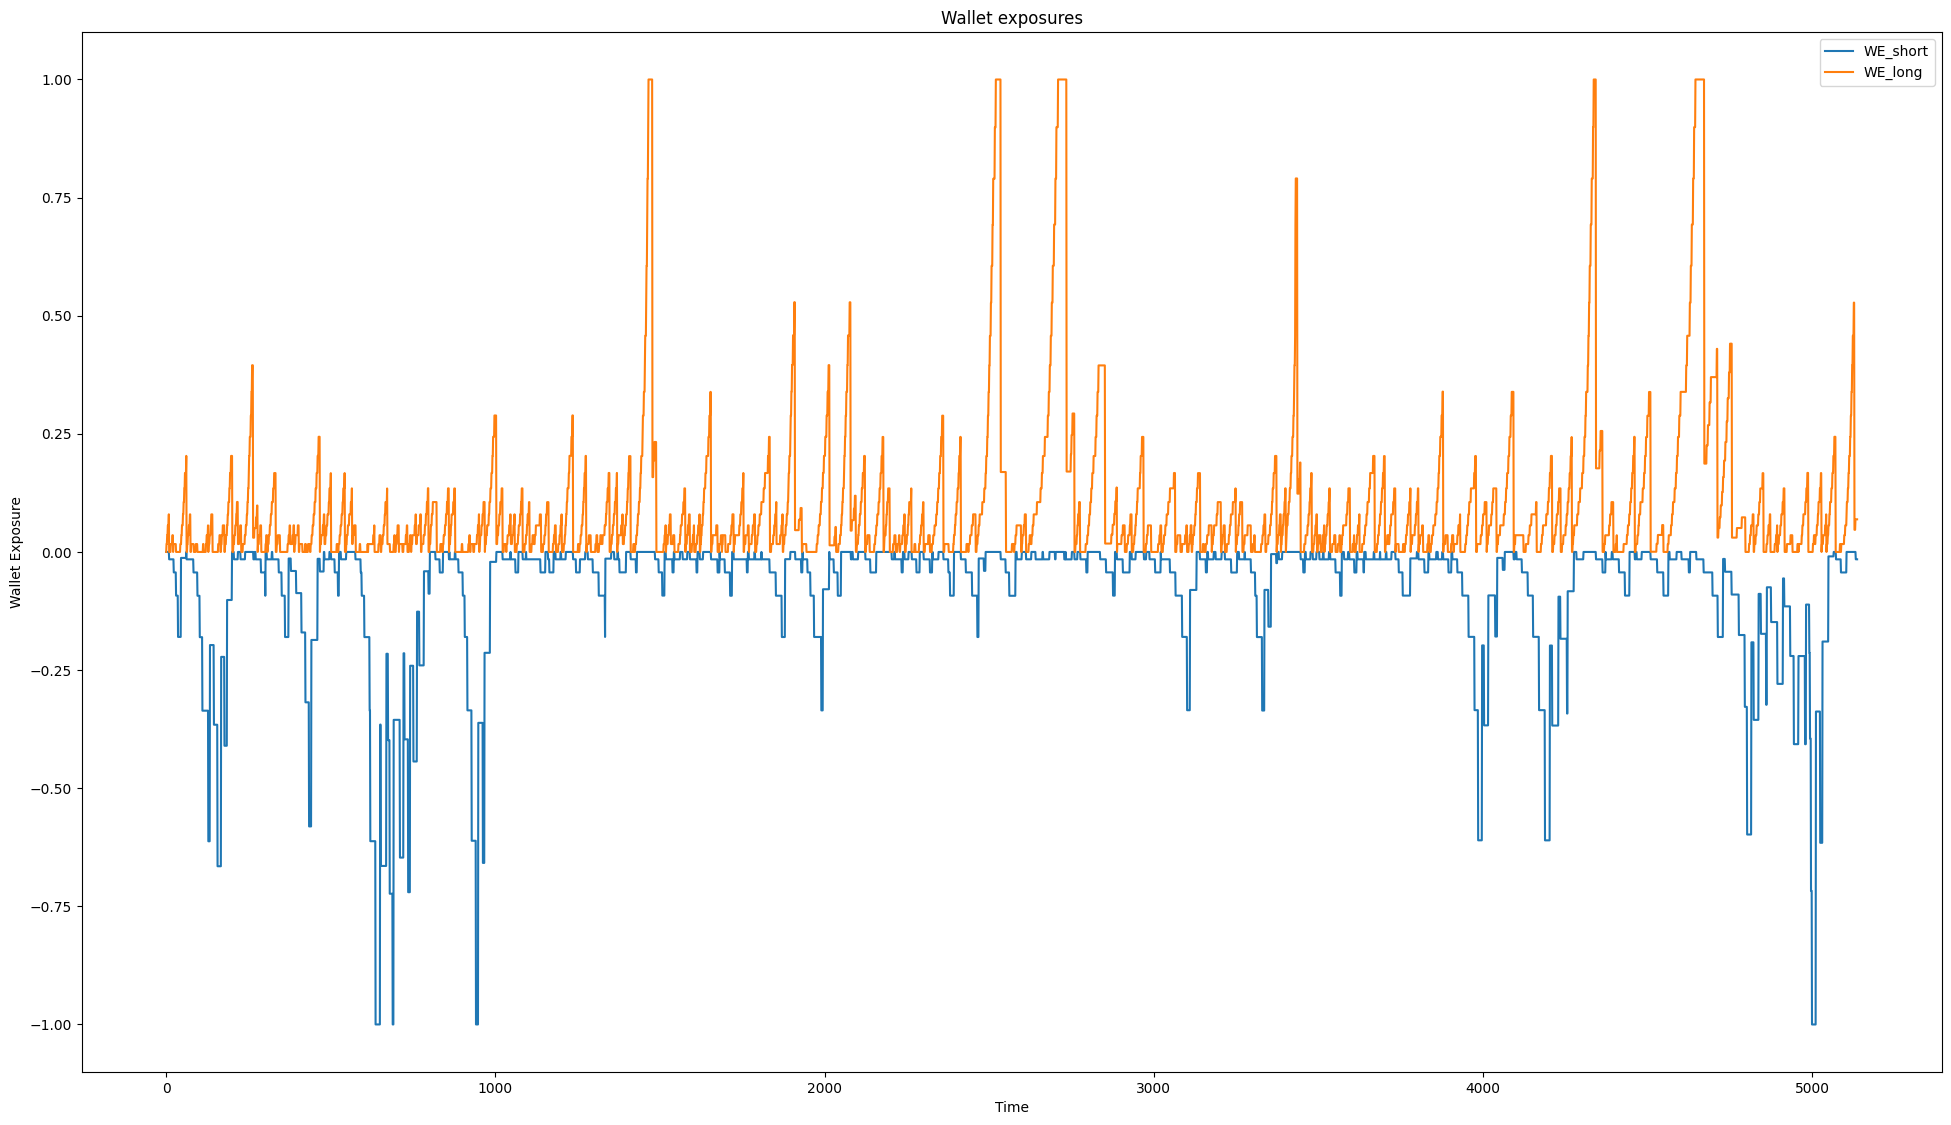

In [13]:
wes = pd.DataFrame(
    {"WE_short": (sdf.wallet_exposure_short.abs() * -1), "WE_long": sdf.wallet_exposure_long}
)
wes.plot(title="Wallet exposures", xlabel="Time", ylabel="Wallet Exposure")

<AxesSubplot:title={'center':'Average entry price'}, xlabel='Time', ylabel='Price'>

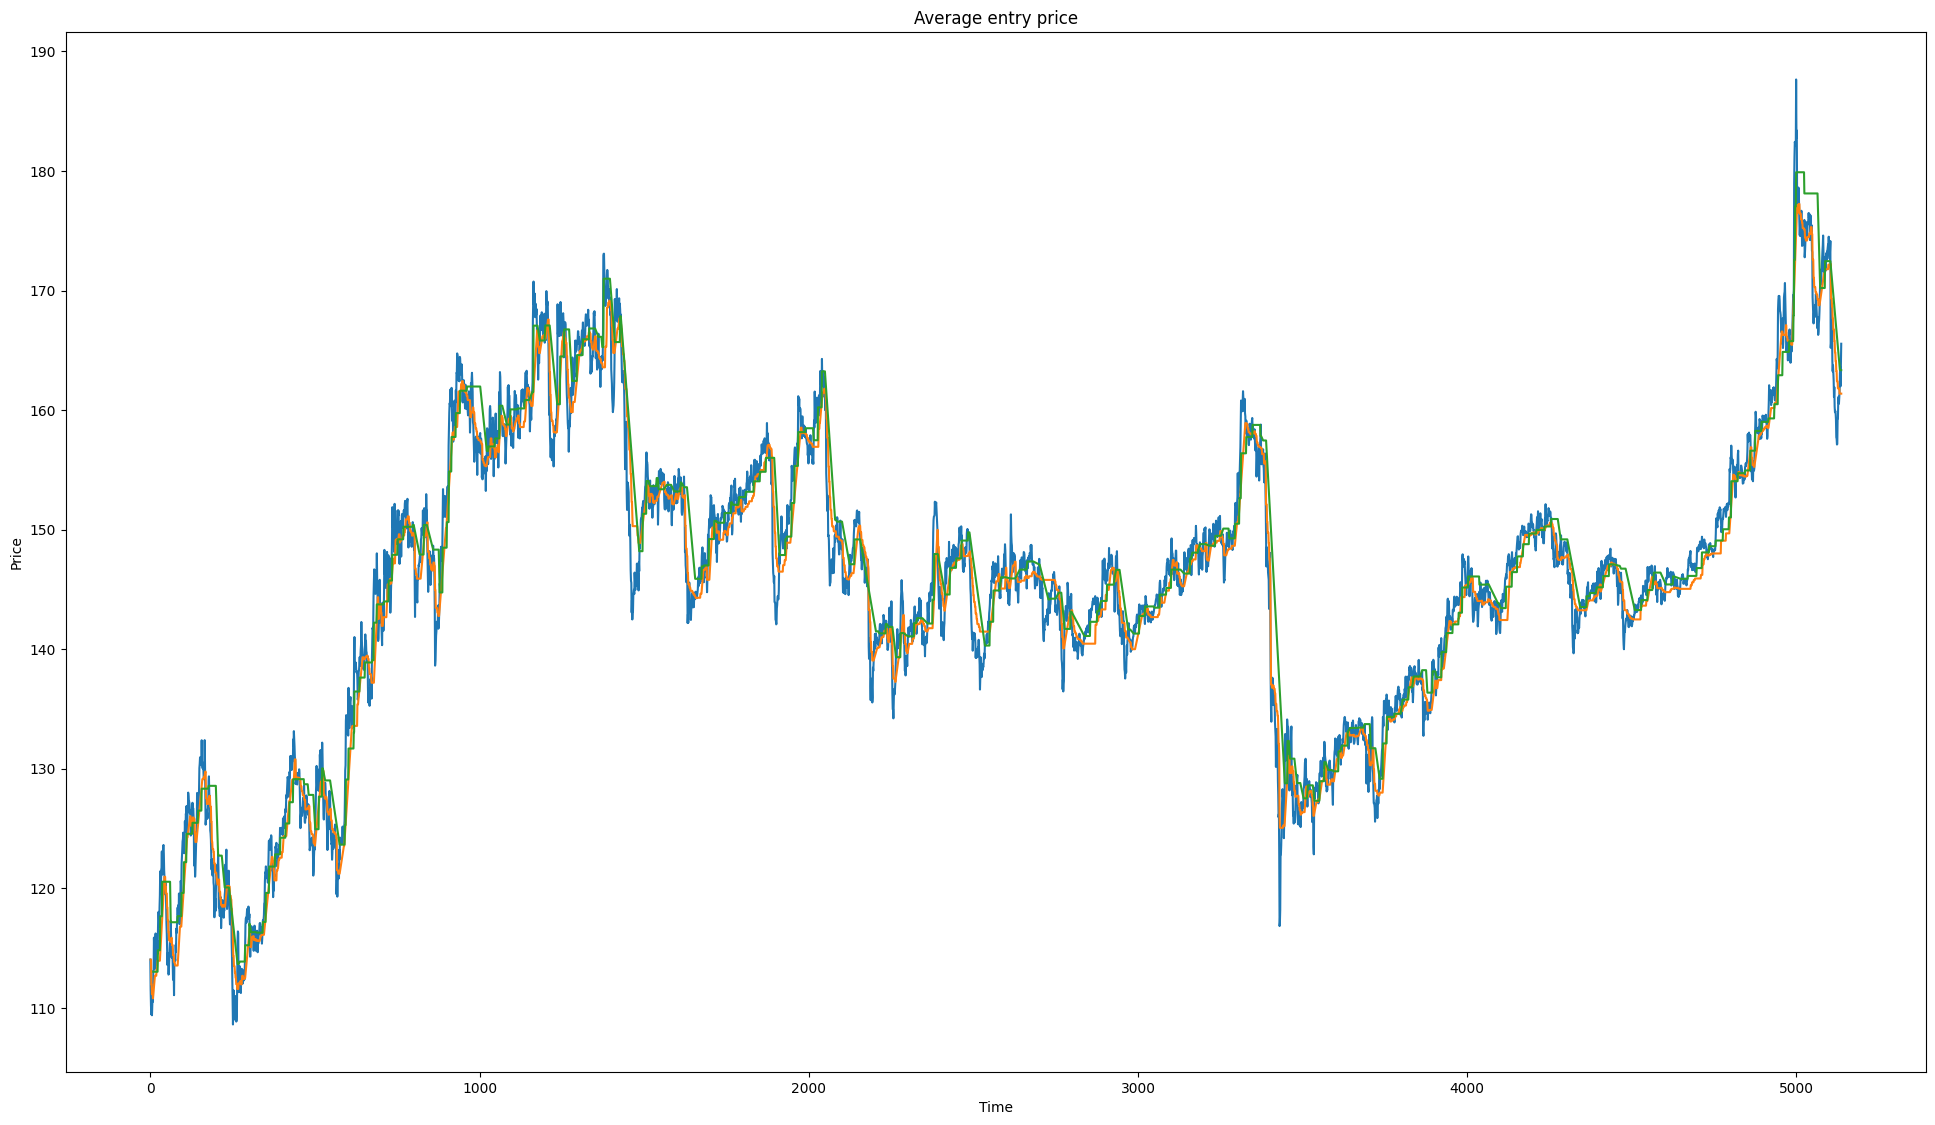

In [14]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf[sdf.psize_long != 0].pprice_long.replace(0.0, np.nan).plot()
sdf[sdf.psize_short != 0].pprice_short.replace(0.0, np.nan).plot()

Price action distance long mean 0.009909 std 0.009483


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

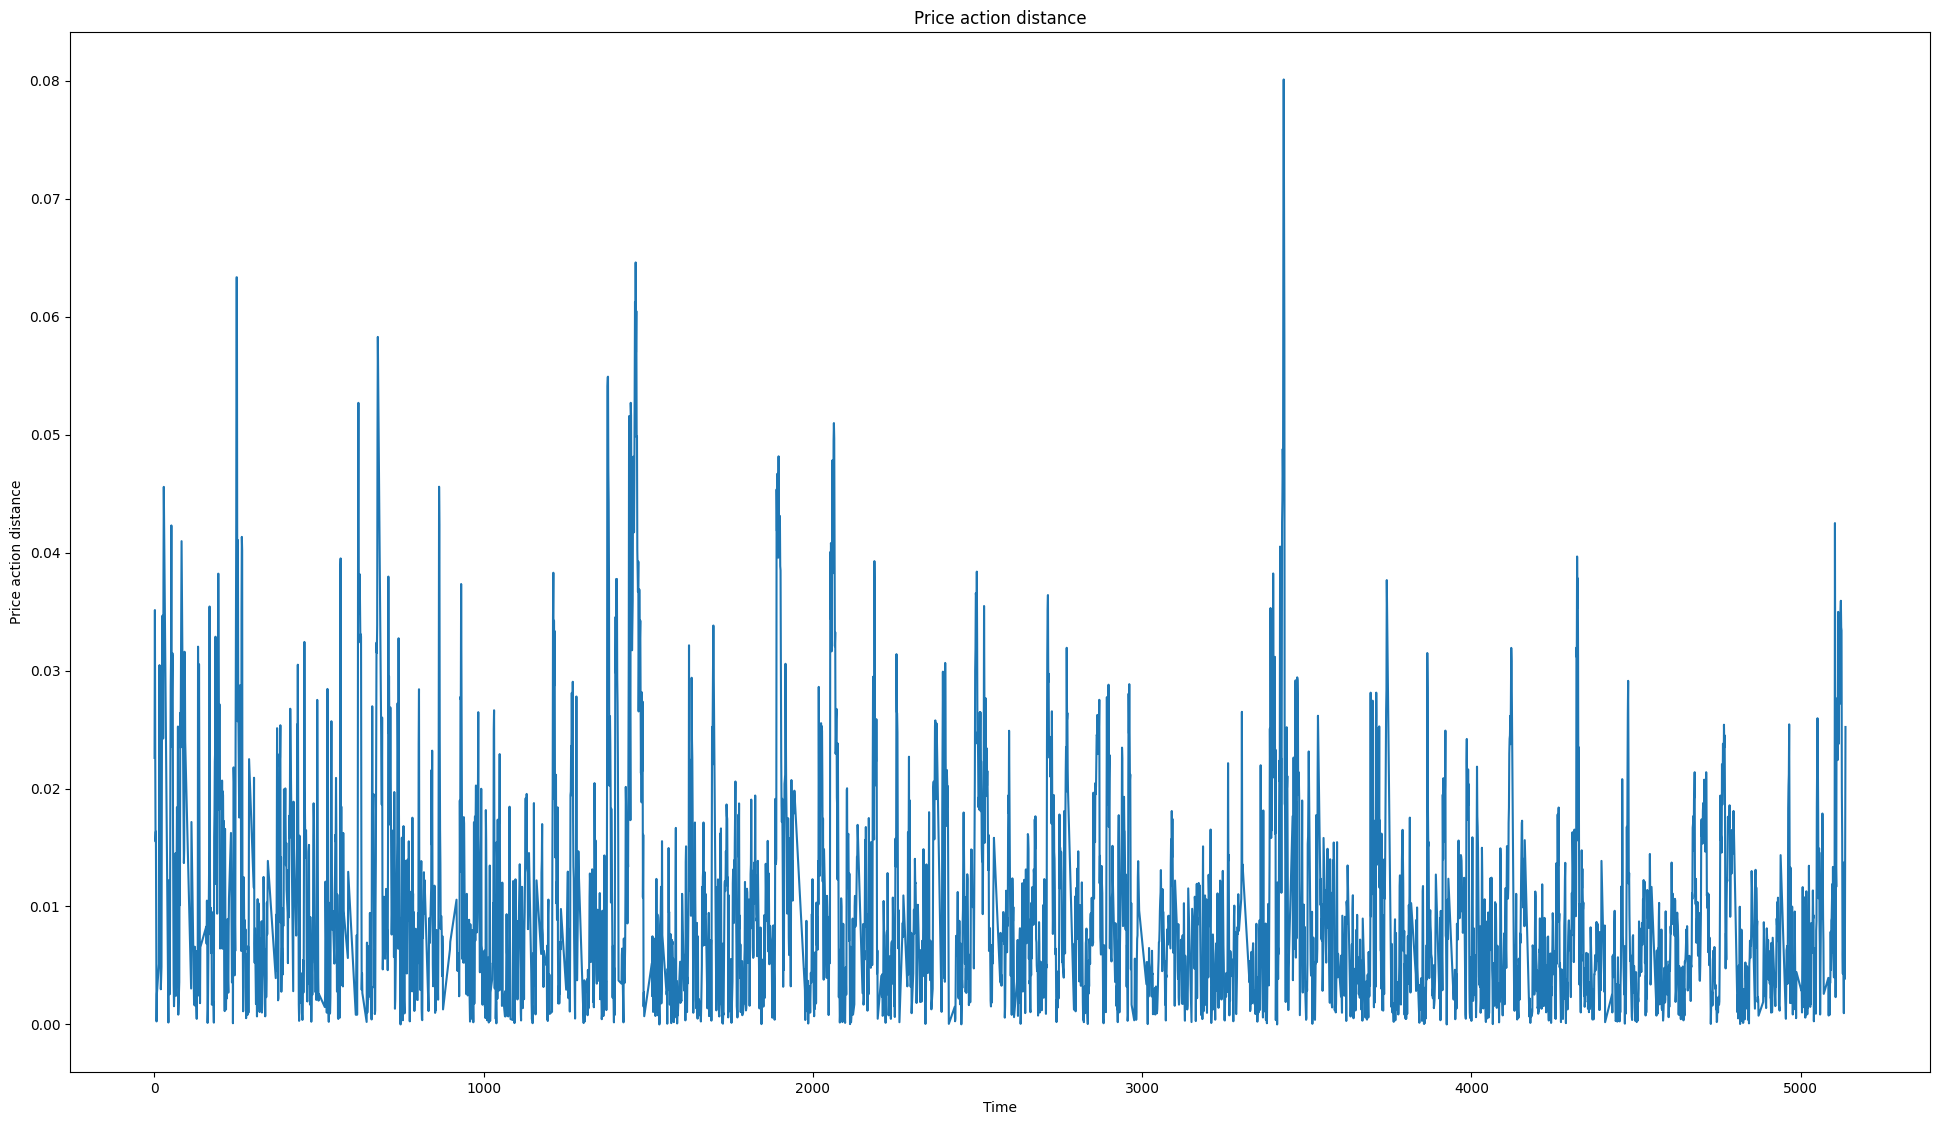

In [15]:
lpprices = sdf[sdf.psize_long != 0.0]
PADistance_long = (lpprices.pprice_long - lpprices.price).abs() / lpprices.price
print(f"Price action distance long mean {PADistance_long.mean():.6f} std {PADistance_long.std():.6f}")
PADistance_long.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

Mean price action distance short 0.011366


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

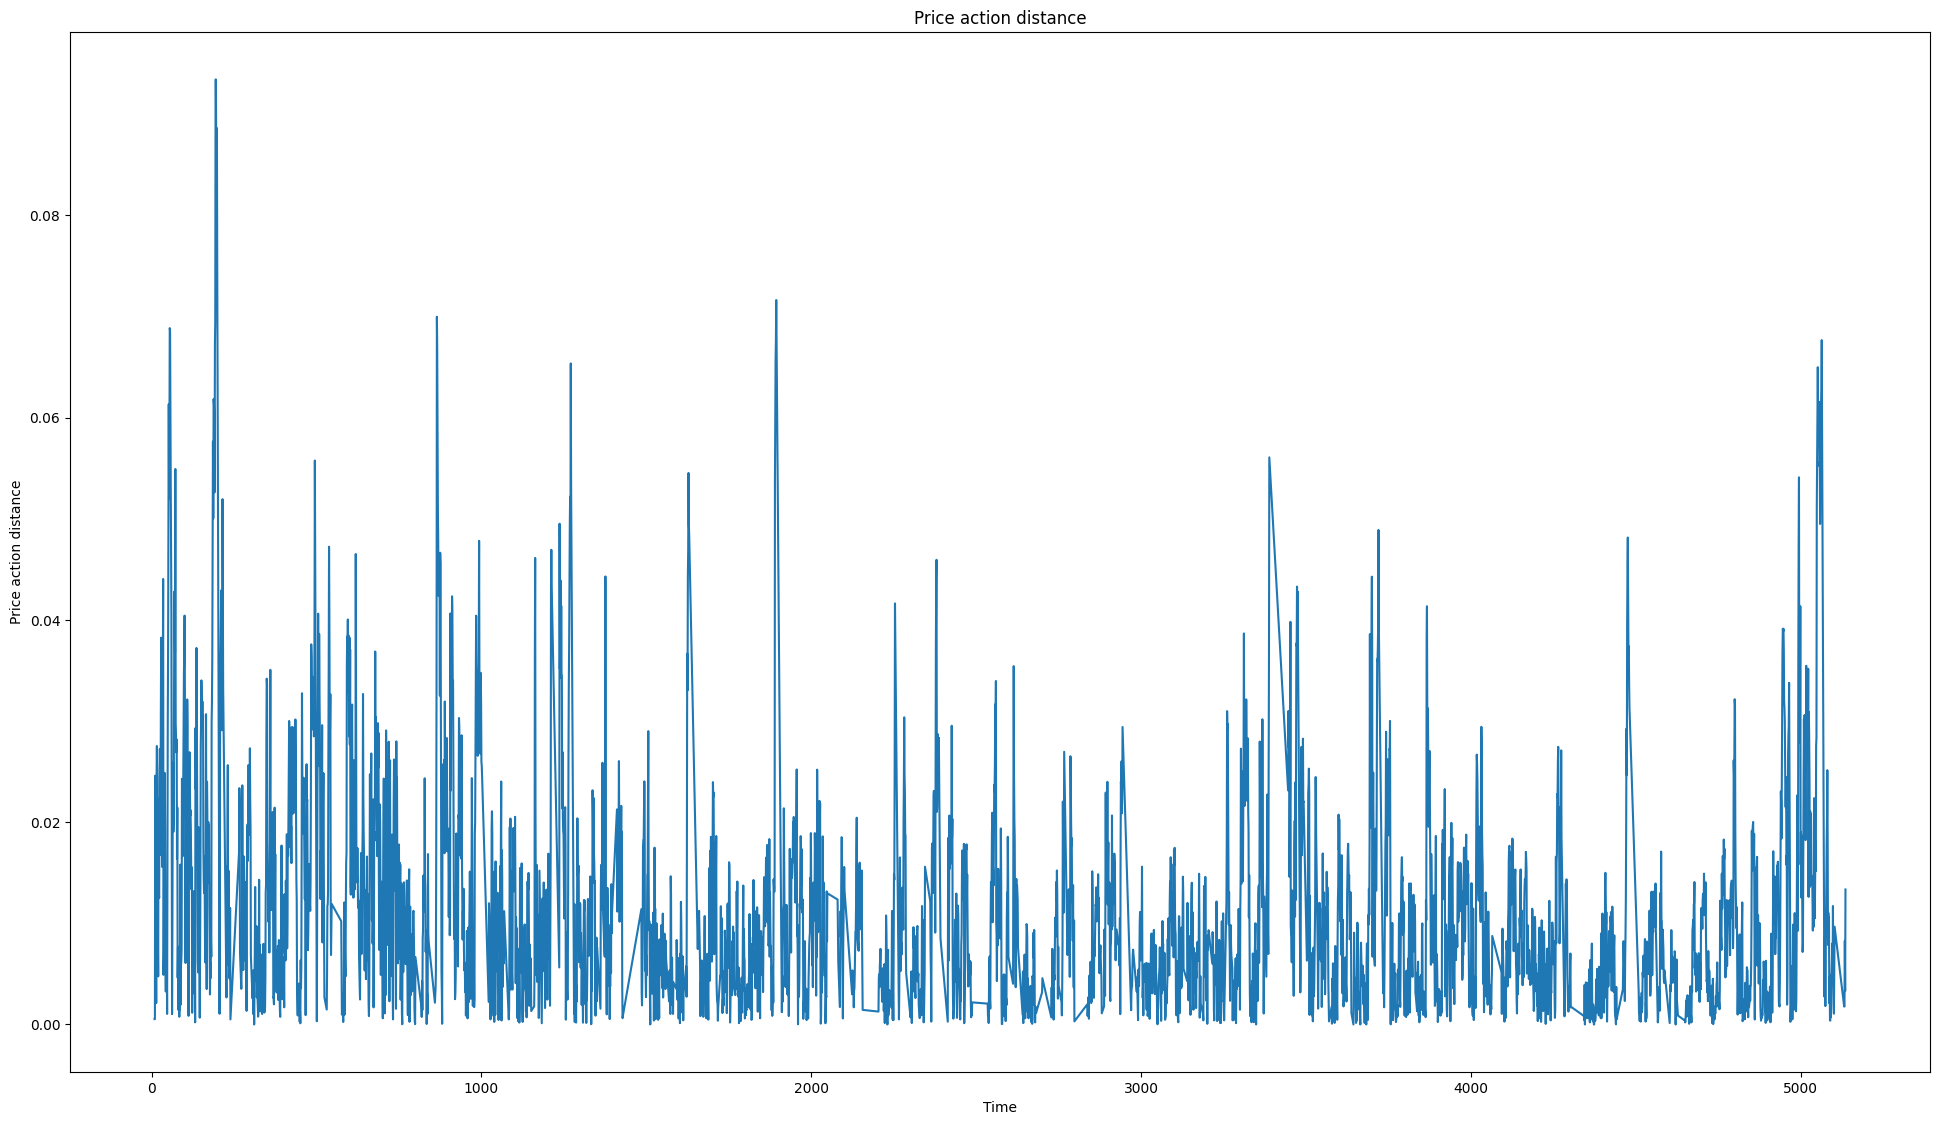

In [16]:
spprices = sdf[sdf.psize_short != 0.0]
PADistance_short = (spprices.pprice_short - spprices.price).abs() / spprices.price
print(f"Mean price action distance short {PADistance_short.mean():.6f}")
PADistance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

<AxesSubplot:xlabel='timestamp'>

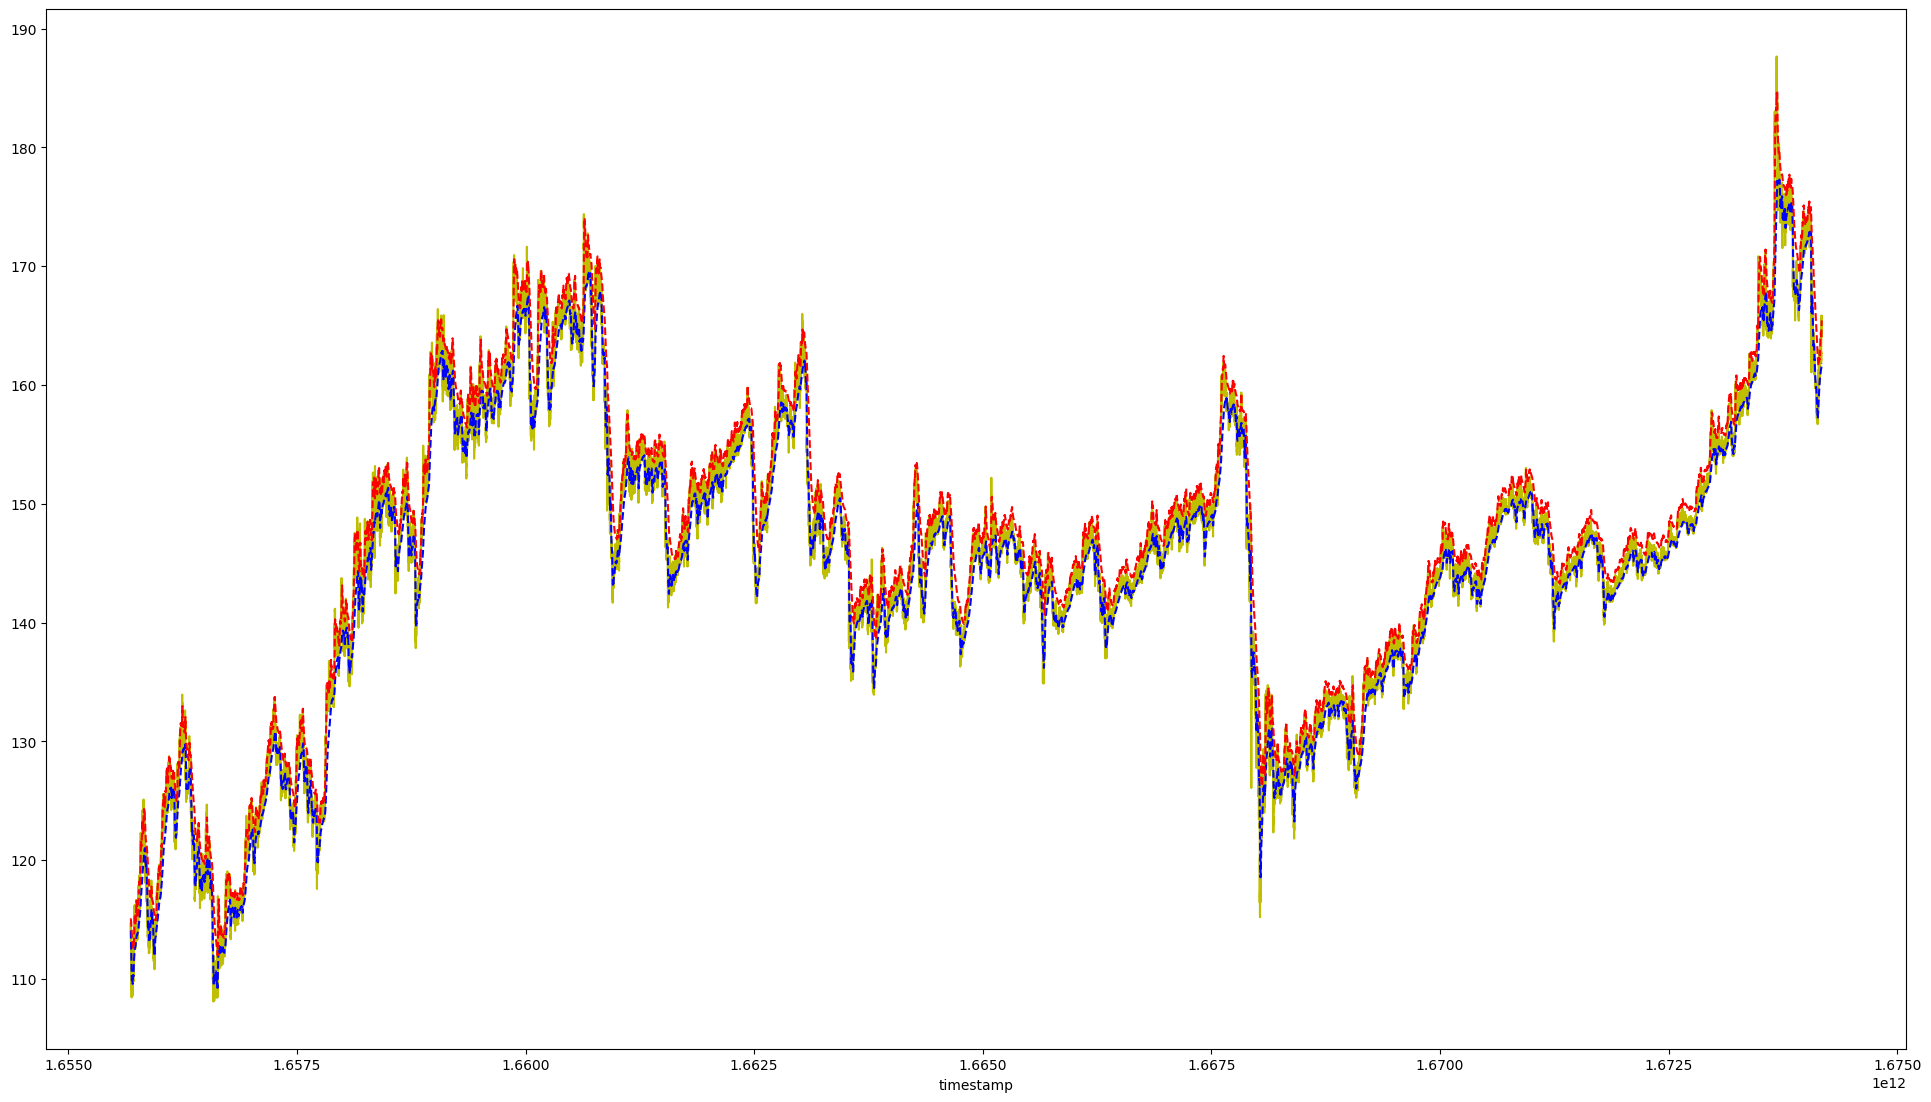

In [17]:
spans_long = sorted(
    [
        config_to_test["long"]["ema_span_0"],
        (config_to_test["long"]["ema_span_0"] * config_to_test["long"]["ema_span_1"]) ** 0.5,
        config_to_test["long"]["ema_span_1"],
    ]
)
emas_long = pd.DataFrame(
    {f"ema_{span}": df.price.ewm(span=span, adjust=False).mean() for span in spans_long},
    index=df.index,
)
ema_bands_long = pd.DataFrame(
    {
        "ema_band_lower": emas_long.min(axis=1) * (1 - config_to_test["long"]["ema_dist_lower"]),
        "ema_band_upper": emas_long.max(axis=1) * (1 + config_to_test["long"]["ema_dist_upper"]),
    },
    index=df.index,
)
df_emas_long = df.join(ema_bands_long)
df_emas_long.price.plot(style="y-")
df_emas_long.ema_band_lower.plot(style="b--")
df_emas_long.ema_band_upper.plot(style="r--")

<AxesSubplot:xlabel='timestamp'>

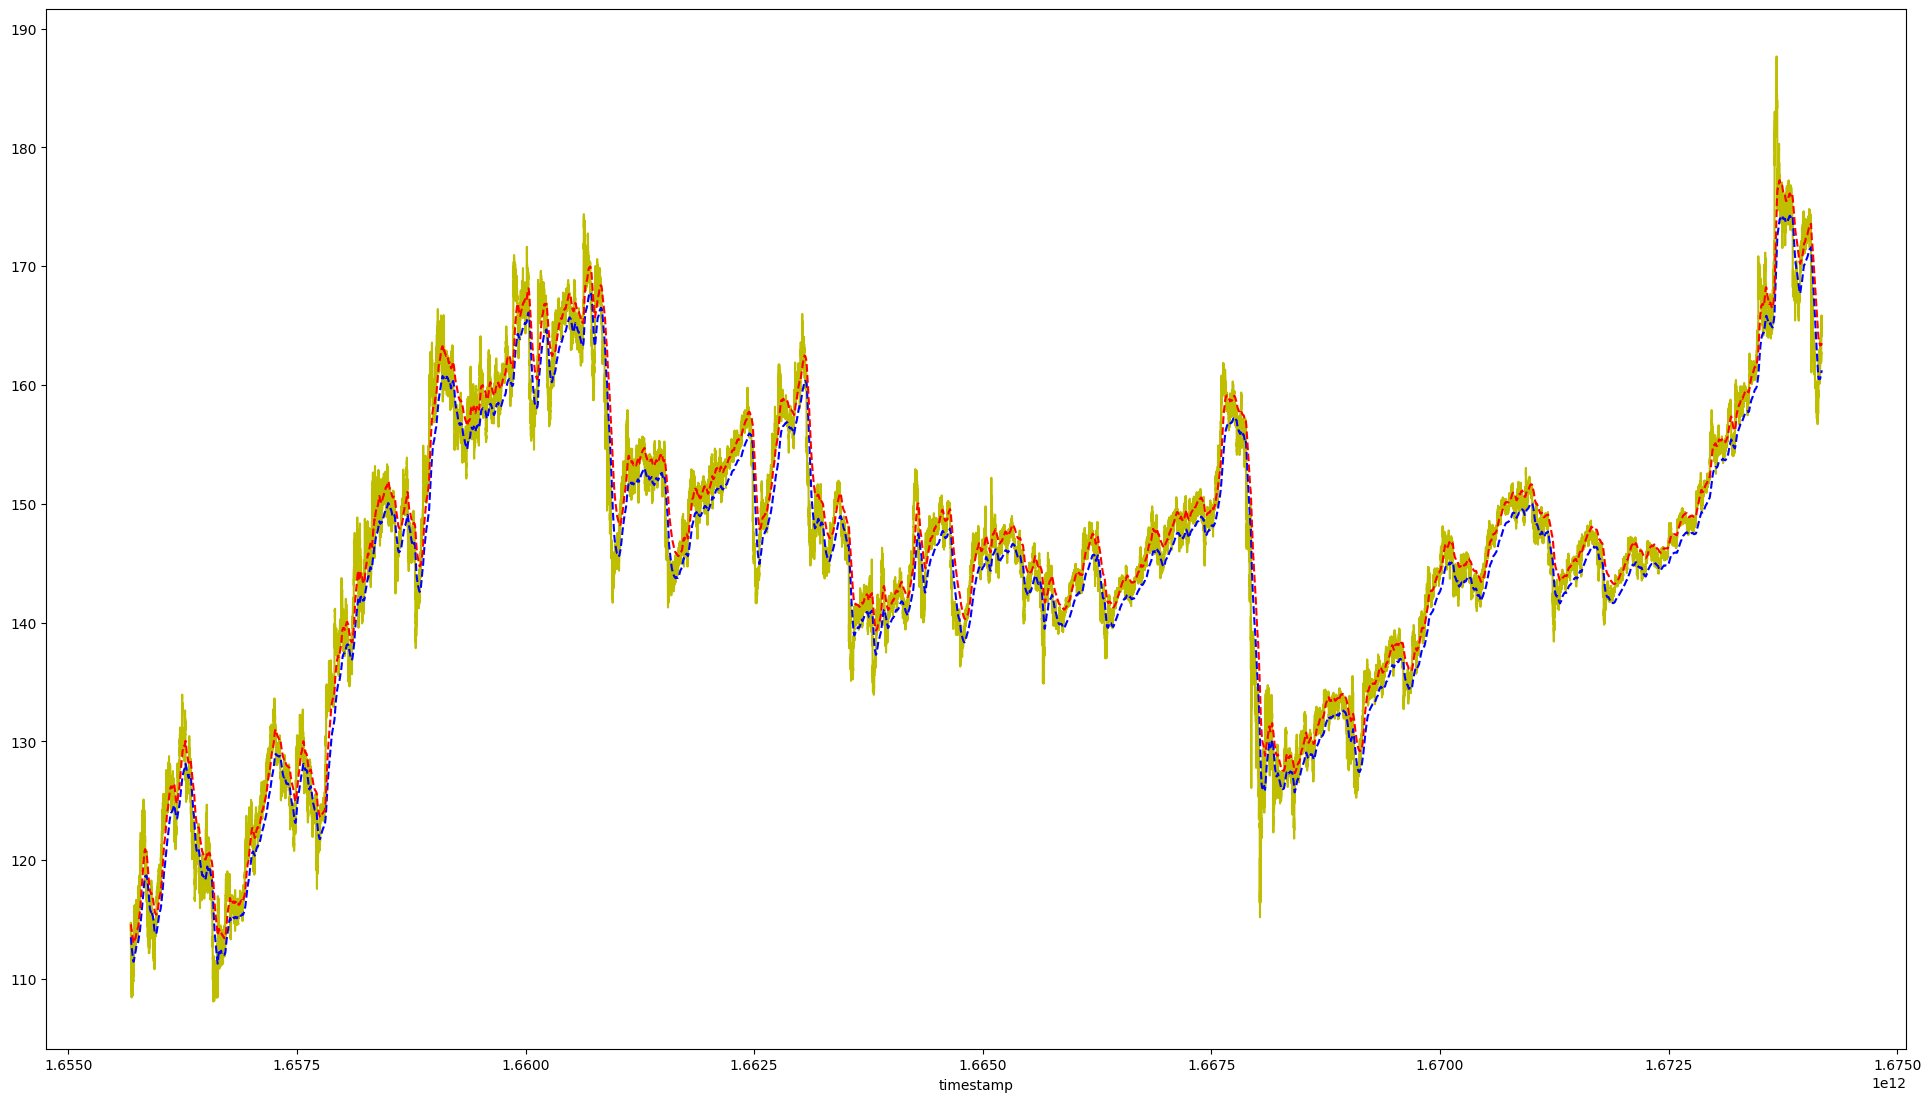

In [18]:
spans_short = sorted(
    [
        config_to_test["short"]["ema_span_0"],
        (config_to_test["short"]["ema_span_0"] * config_to_test["short"]["ema_span_1"]) ** 0.5,
        config_to_test["short"]["ema_span_1"],
    ]
)
emas_short = pd.DataFrame(
    {f"ema_{span}": df.price.ewm(span=span, adjust=False).mean() for span in spans_short},
    index=df.index,
)
ema_bands_short = pd.DataFrame(
    {
        "ema_band_lower": emas_short.min(axis=1) * (1 - config_to_test["short"]["ema_dist_lower"]),
        "ema_band_upper": emas_short.max(axis=1) * (1 + config_to_test["short"]["ema_dist_upper"]),
    },
    index=df.index,
)
df_emas_short = df.join(ema_bands_short)
df_emas_short.price.plot(style="y-")
df_emas_short.ema_band_lower.plot(style="b--")
df_emas_short.ema_band_upper.plot(style="r--")